## Node class and method for computing node distances
Finding sorted position of every node to every other node is $\mathcal{O}(n^2\log{n})$. Pretty inefficient.

In [1]:
import numpy
from typing import List, Tuple

class Node:
    pos: numpy.array

    def __init__(self, pos):
        self.pos = pos

def compute_distances(nodes: List[Node]) -> List[List[Tuple[int, float]]]:
    """ return list (node_index, distance) pairs for every node. Distanced get sorted in ascending order. """
    distances = [[] for node in nodes]
    for i, node_a in enumerate(nodes):
        for j, node_b in enumerate(nodes):
            if i != j:
                node_tuple = (j, numpy.linalg.norm(node_a.pos - node_b.pos))
                distances[i].append(node_tuple)
        distances[i] = sorted(distances[i], key=lambda x: x[1])
    return distances

## Method returning angle in rads between two vectors

In [485]:
import numpy

# https://chadrick-kwag.net/get-rotation-angle-between-two-vectors/
def compute_rotation_angle(a, b):
    """ return rotation angle from vector a to vector b, in degrees.
    Args:
        a : np.array vector. format (x,y)
        b : np.array vector. format (x,y)
    Returns:
        angle [float]: degrees. 0~360
    """
    unit_vector_1 = a / numpy.linalg.norm(a)
    unit_vector_2 = b / numpy.linalg.norm(b)
    dot_product = numpy.dot(unit_vector_1, unit_vector_2)
    # Angle in radians
    angle = numpy.arccos(dot_product)
    # Determines how perpendicular two vectors are
    # 1 or -1 == completely perpendicalar, sign indicating direction
    # 0 == completely parallel
    c = numpy.cross(b,a)
    if c>0:
        angle = (2 * numpy.pi) - angle
    
    return angle

# Example use
# compute_rotation_angle([0, 1], [1, 0])

## Angle-based connection trial

![Angle diff logic](./angle_diff.png)

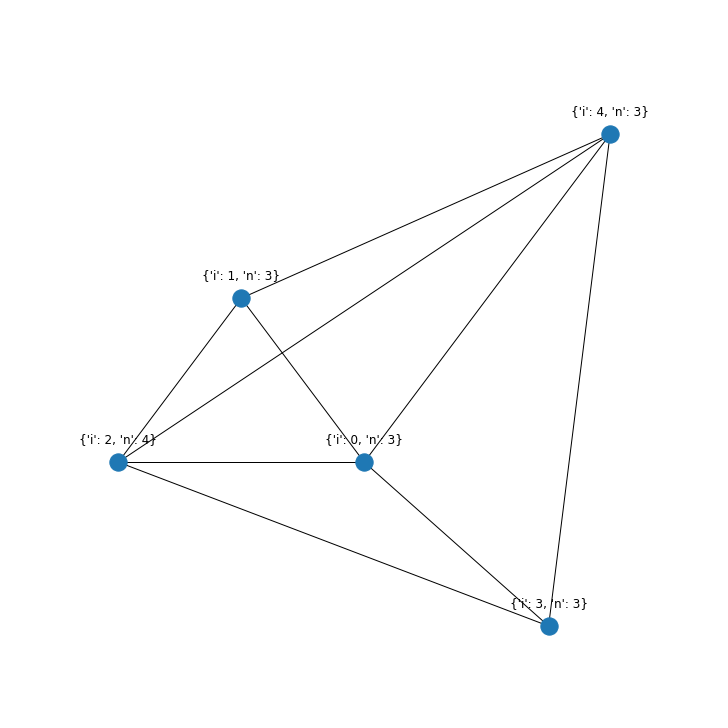

In [636]:
def get_angle_distance(a, b):
    """
    Returns the distance between two angles between 0 to 2pi radians.
    Will always return the smaller non-reflex angle.
    """
    if (a < numpy.pi and b < numpy.pi) or (a > numpy.pi and b > numpy.pi):
        return abs(a - b)
    else:
        if a > numpy.pi: a, b = b, a
        return min(
            a + (2 * numpy.pi) - b,
            (numpy.pi - a) + (b - numpy.pi)
        )

def is_angle_between(a, b, theta):
    # Ensure a <= b
    if b < a:
        a, b = b, a
    
    offset = a
    a, b = 0, b - offset
    theta = theta - offset
    # Ensure theta is positive
    if theta < 0: theta = (numpy.pi * 2) + theta
    return a <= theta <= b

def connect_nodes(nodes: List[Node]) -> None:
    LEFT_VECTOR = [1, 0]
    distances = compute_distances(nodes)
    g = nx.Graph()
    labels = dict()
    for node_idx in range(0, len(nodes)):
        g.add_node(node_idx, pos=nodes[node_idx].pos)
        
        c = 0
        left = None
        right = None
        is_reflex_angle = False
        
        while distances[node_idx]:
            # First set left and right boundaries
            if not left:
                neighbor_idx, neighbor_distance = distances[node_idx].pop(0)
                angle = compute_rotation_angle(LEFT_VECTOR, nodes[neighbor_idx].pos - nodes[node_idx].pos)
                left = angle
                g.add_edge(node_idx, neighbor_idx)
                c += 1
                continue
            if not right:
                neighbor_idx, neighbor_distance = distances[node_idx].pop(0)
                angle = compute_rotation_angle(LEFT_VECTOR, nodes[neighbor_idx].pos - nodes[node_idx].pos)
                g.add_edge(node_idx, neighbor_idx)
                right = angle
                # Ensure left boundary angle is smaller than right boundary angle
                if left > right: left, right = right, left
                # Flag the boundary area angle as a reflex angle
                if abs(right - left) > numpy.pi: is_reflex_angle = True
                c += 1
                continue
                
            """ Connect additional neighbors after setting initial boundaries """
            neighbor_idx, neighbor_distance = distances[node_idx].pop(0)
            angle = compute_rotation_angle(LEFT_VECTOR, nodes[neighbor_idx].pos - nodes[node_idx].pos)
            
            # Skip potential neighbors which fall between the current boundary angles
            if (not is_reflex_angle and is_angle_between(left, right, angle))\
            or (is_reflex_angle and not is_angle_between(left, right, angle)):
                continue
            
            if get_angle_distance(left, angle) < get_angle_distance(right, angle):
                left = angle
            else:
                right = angle
            g.add_edge(node_idx, neighbor_idx)
            
            # Flag the boundary angle as a reflex angle
            if not is_reflex_angle and abs(right - left) > numpy.pi: is_reflex_angle = True
                
        labels[node_idx] = {
            'i': node_idx,
            'n': c  # number of connected nodes
        }
    
    """ Draw the connected graph """
    fig, ax = pyplot.subplots(1,1,figsize=(10,10), layout="constrained")
    pos = nx.get_node_attributes(g,'pos')
    SHIFT_AMOUNT = 0.1
    label_pos = {k: (v[0], v[1] + SHIFT_AMOUNT) for k, v in pos.items()}
    nx.draw(g, pos=pos, with_labels=False, ax=ax)
    # https://stackoverflow.com/questions/14547388/networkx-in-python-draw-node-attributes-as-labels-outside-the-node
    nx.draw_networkx_labels(g, pos=label_pos, labels=labels, verticalalignment="bottom")
    ax.set_xlim(tuple(i*1.2 for i in ax.get_xlim()))      # expand plot to fit labels
    ax.set_ylim(tuple(i*1.2 for i in ax.get_ylim()))      # expand plot to fit labels
    pyplot.show()
    
nodes = [
    Node(numpy.array([0, 0])),
    Node(numpy.array([-1, 1])),
    Node(numpy.array([-2, 0])),
    Node(numpy.array([1.5, -1])),
    Node(numpy.array([2, 2])) # The algorithm should not connect this one
]
connect_nodes(nodes)

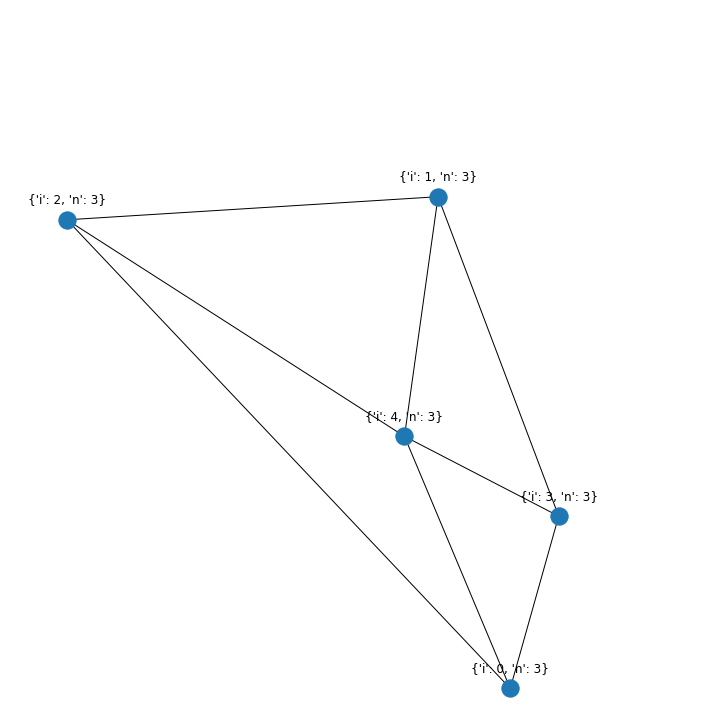

In [678]:
import numpy
import networkx as nx
import matplotlib.pyplot as plt
import copy

N_NODES = 5
nodes = []
for i in range(0, N_NODES):
    node = Node(
        numpy.random.rand(2) * 5
    )
    nodes.append(node)

connect_nodes(nodes)